# 1. Setup

In [1]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
# from scipy.stats import entropy

from utils import *

# 2. Updated trips

## 2.1. Load data

In [3]:
trips = pd.read_parquet('../data/trips2.parquet').disp()

727,167 rows x 8 cols; Memory: 20.1 MiB


,Duration,Distance,Speed,Mode,Purpose,StayTime,MSAKind,FlowType
,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>
0,16.182075,8.439379,31.291583,Drive,Social,Mid,Small,S → S


In [5]:
factors = D(Mode='crimson', Purpose='dodgerblue', StayTime='forestgreen',
            MSAKind='slateblue', FlowType='orchid')

## 2.2. Distributions of finalized factors

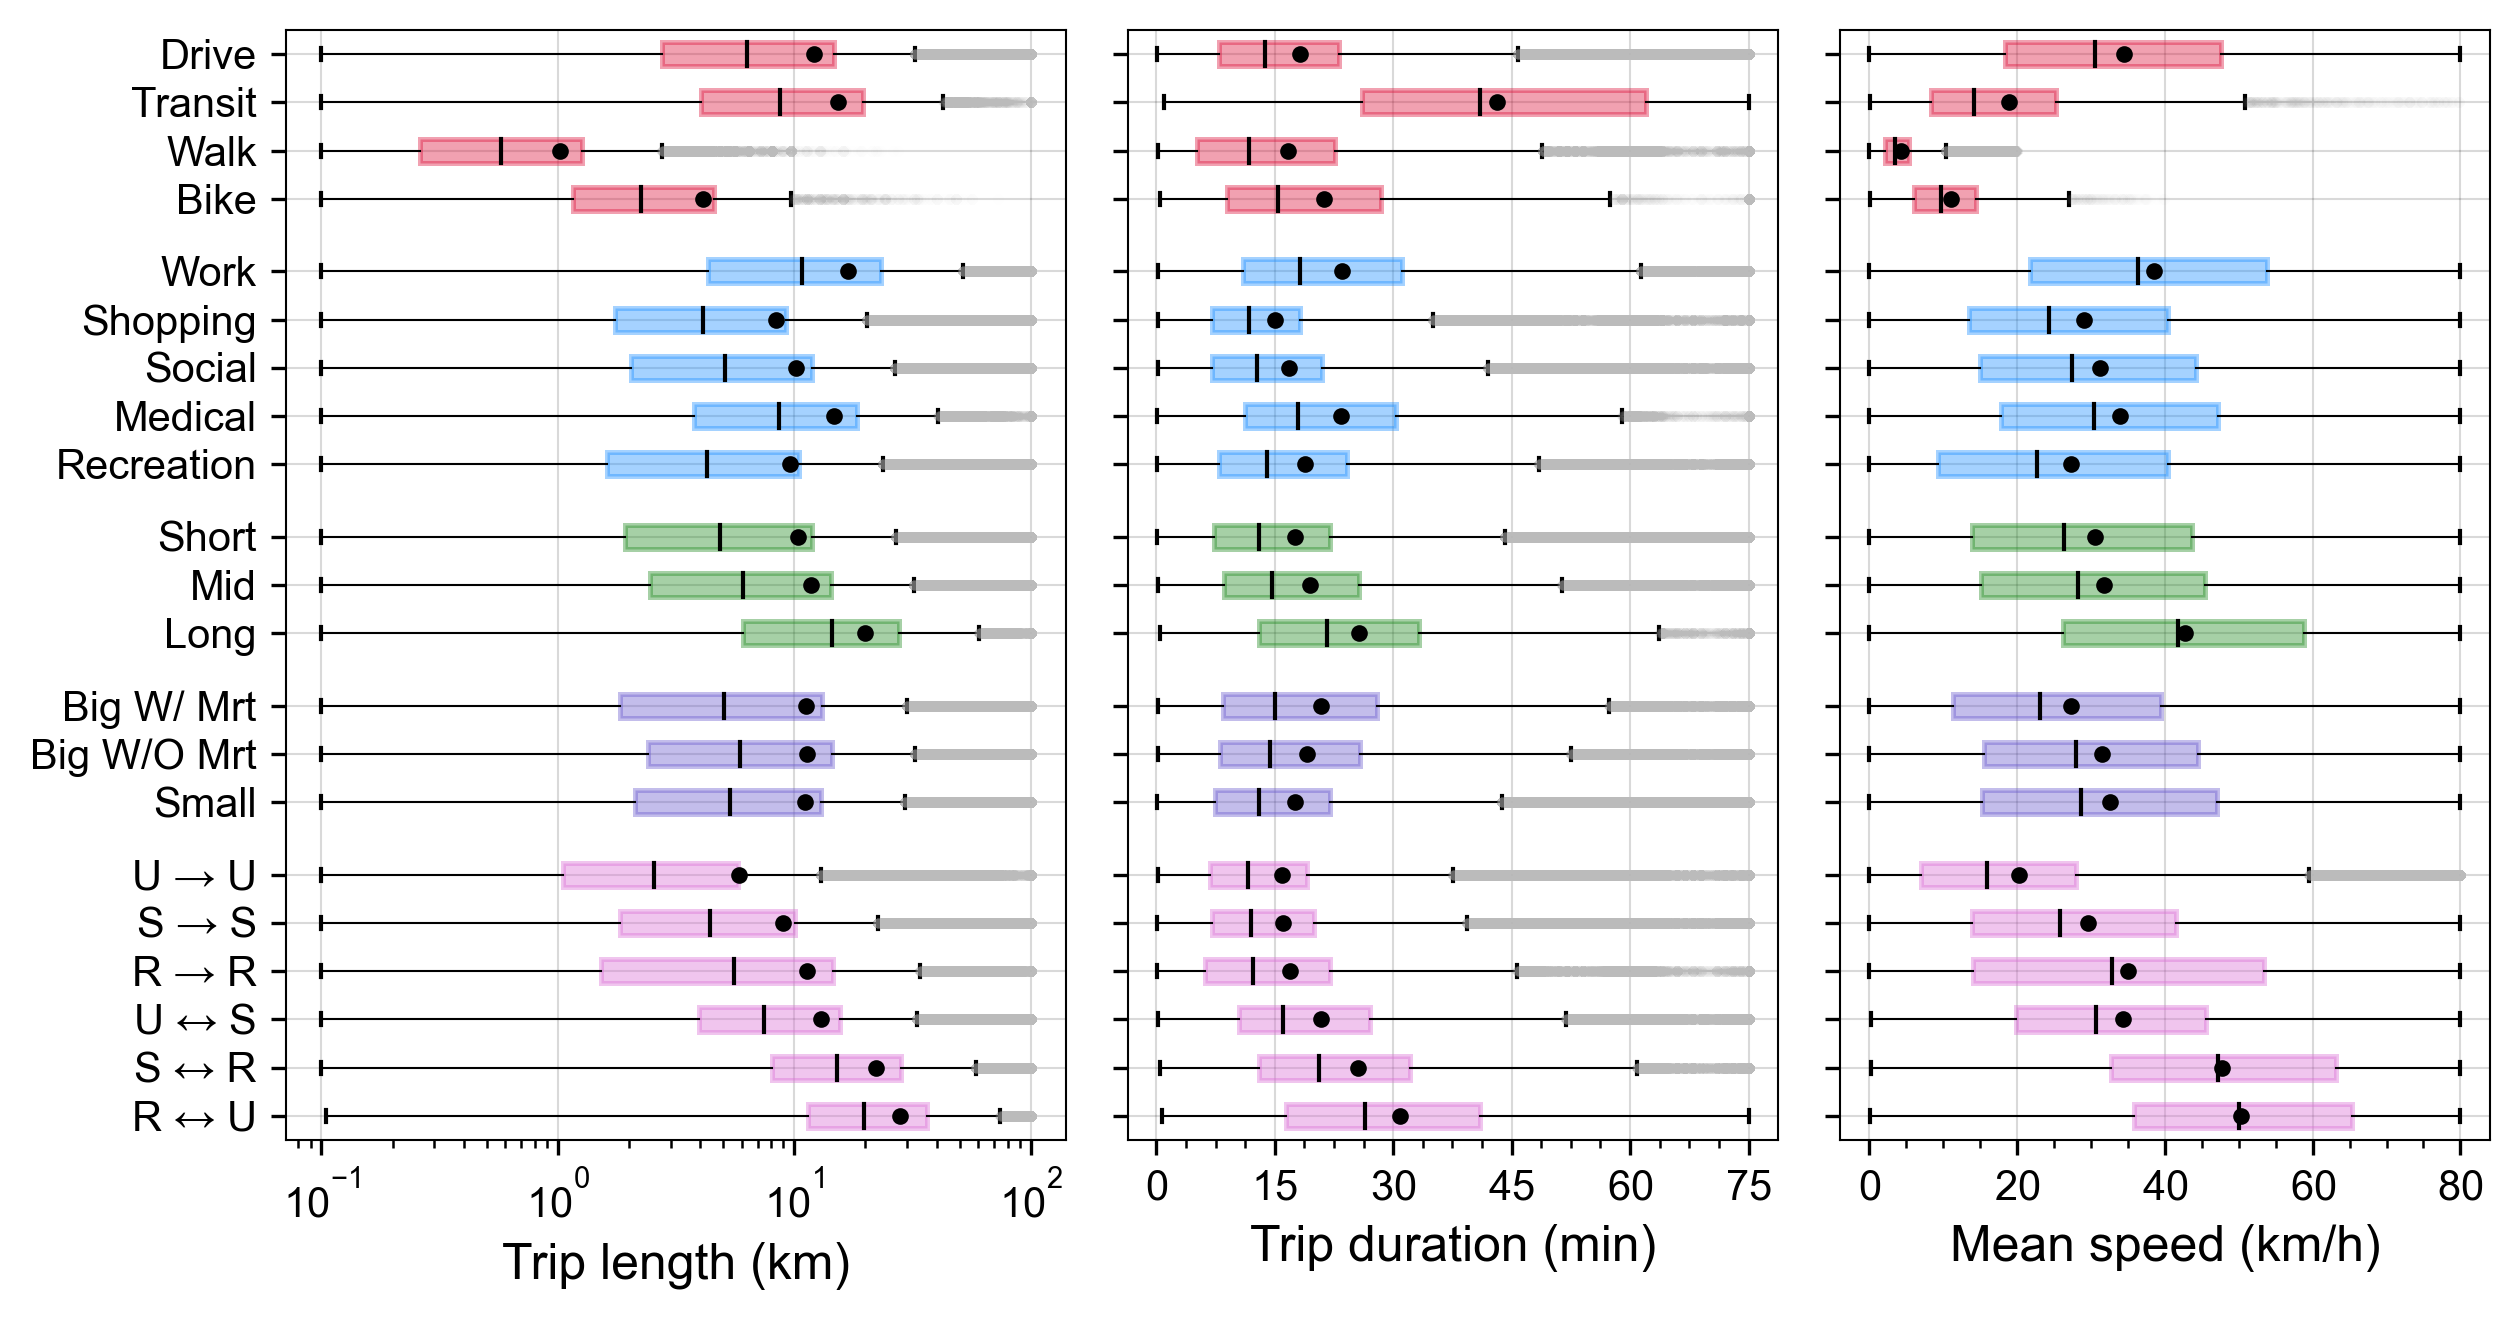

In [6]:
def plot_distr_box(trips=trips, factors=factors, dpi=150):
    _, axes = plt.subplots(1, 3, figsize=(8.5, 4.5), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, (var, label, rng) in enumerate([
            ('Distance', 'Trip length (km)', (0.1, 100)),
            ('Duration', 'Trip duration (min)', (0, 75)),
            ('Speed', 'Mean speed (km/h)', (0, 80))]):
        df = Pdf(sum([[D(col=col, cat=x[0].title().replace('_', ' '),
                         vals=x[1].values, pos=i / 2, n=ticker(len(x[1]))) 
                       for x in trips.groupby(col)[var]]
                      for i, col in enumerate(factors.keys())], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(factors)
        ax = pplot(axes[j], xlog=var == 'Distance')
        ax.set_xlabel(label, fontsize=12)
        x = ax.boxplot(
            df.vals, positions=df.pos + df.index, labels=df.cat, patch_artist=1,
            vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2, alpha=0.4),
            flierprops=D(markersize=1.5, markeredgecolor='#bbb', alpha=0.01),
            showmeans=True, meanline=False, medianprops=D(color='k'),
            meanprops=D(markersize=4, markeredgecolor='none',
                        marker='o', markerfacecolor='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if var == 'Duration': ax.set_xticks(np.arange(0, 75+1, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()
    imsave('Distributions of finalized variables')

x = plot_distr_box(dpi=300); x # t=0:07

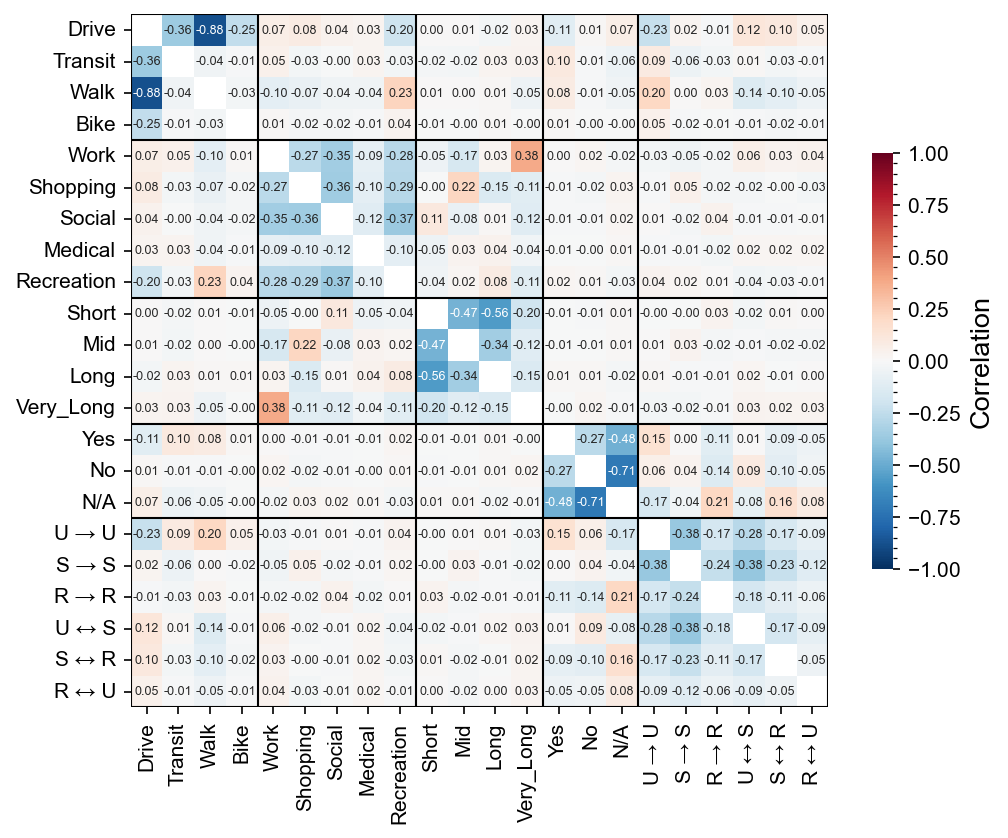

In [5]:
def plot_corr_final_vars(trips=trips, factors=sel_factors, size=(7.5, 6), dpi=150, cmap='RdBu_r'):
    X = pd.get_dummies(trips[factors.keys()], prefix_sep='__')
    corr = X.corr()
    np.fill_diagonal(corr.values, np.nan)
    ax = pplot(size=size, dpi=dpi, xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1] for x in X.columns]
    ax = sns.heatmap(corr, ax=ax, cmap=cmap, vmin=-1, vmax=1,
                     xticklabels=labels, yticklabels=labels,
                     cbar=True, cbar_kws=D(shrink=0.6, label='Correlation'),
                     annot=True, fmt='.2f', annot_kws=D(fontsize=6))
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    for x in list(cols.idx[cols.idx].index) + [len(cols)]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)

x = plot_corr_final_vars(); x

# 3. Impedance function

## 3.1. Distributions

790 rows x 7 cols; Memory: 0.3 MiB


,Mode,Purpose,StayTime,Subway,FlowType,AUC,Target
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>
0,Transit,Work,Short,Yes,U ↔ S,0.562148,Duration


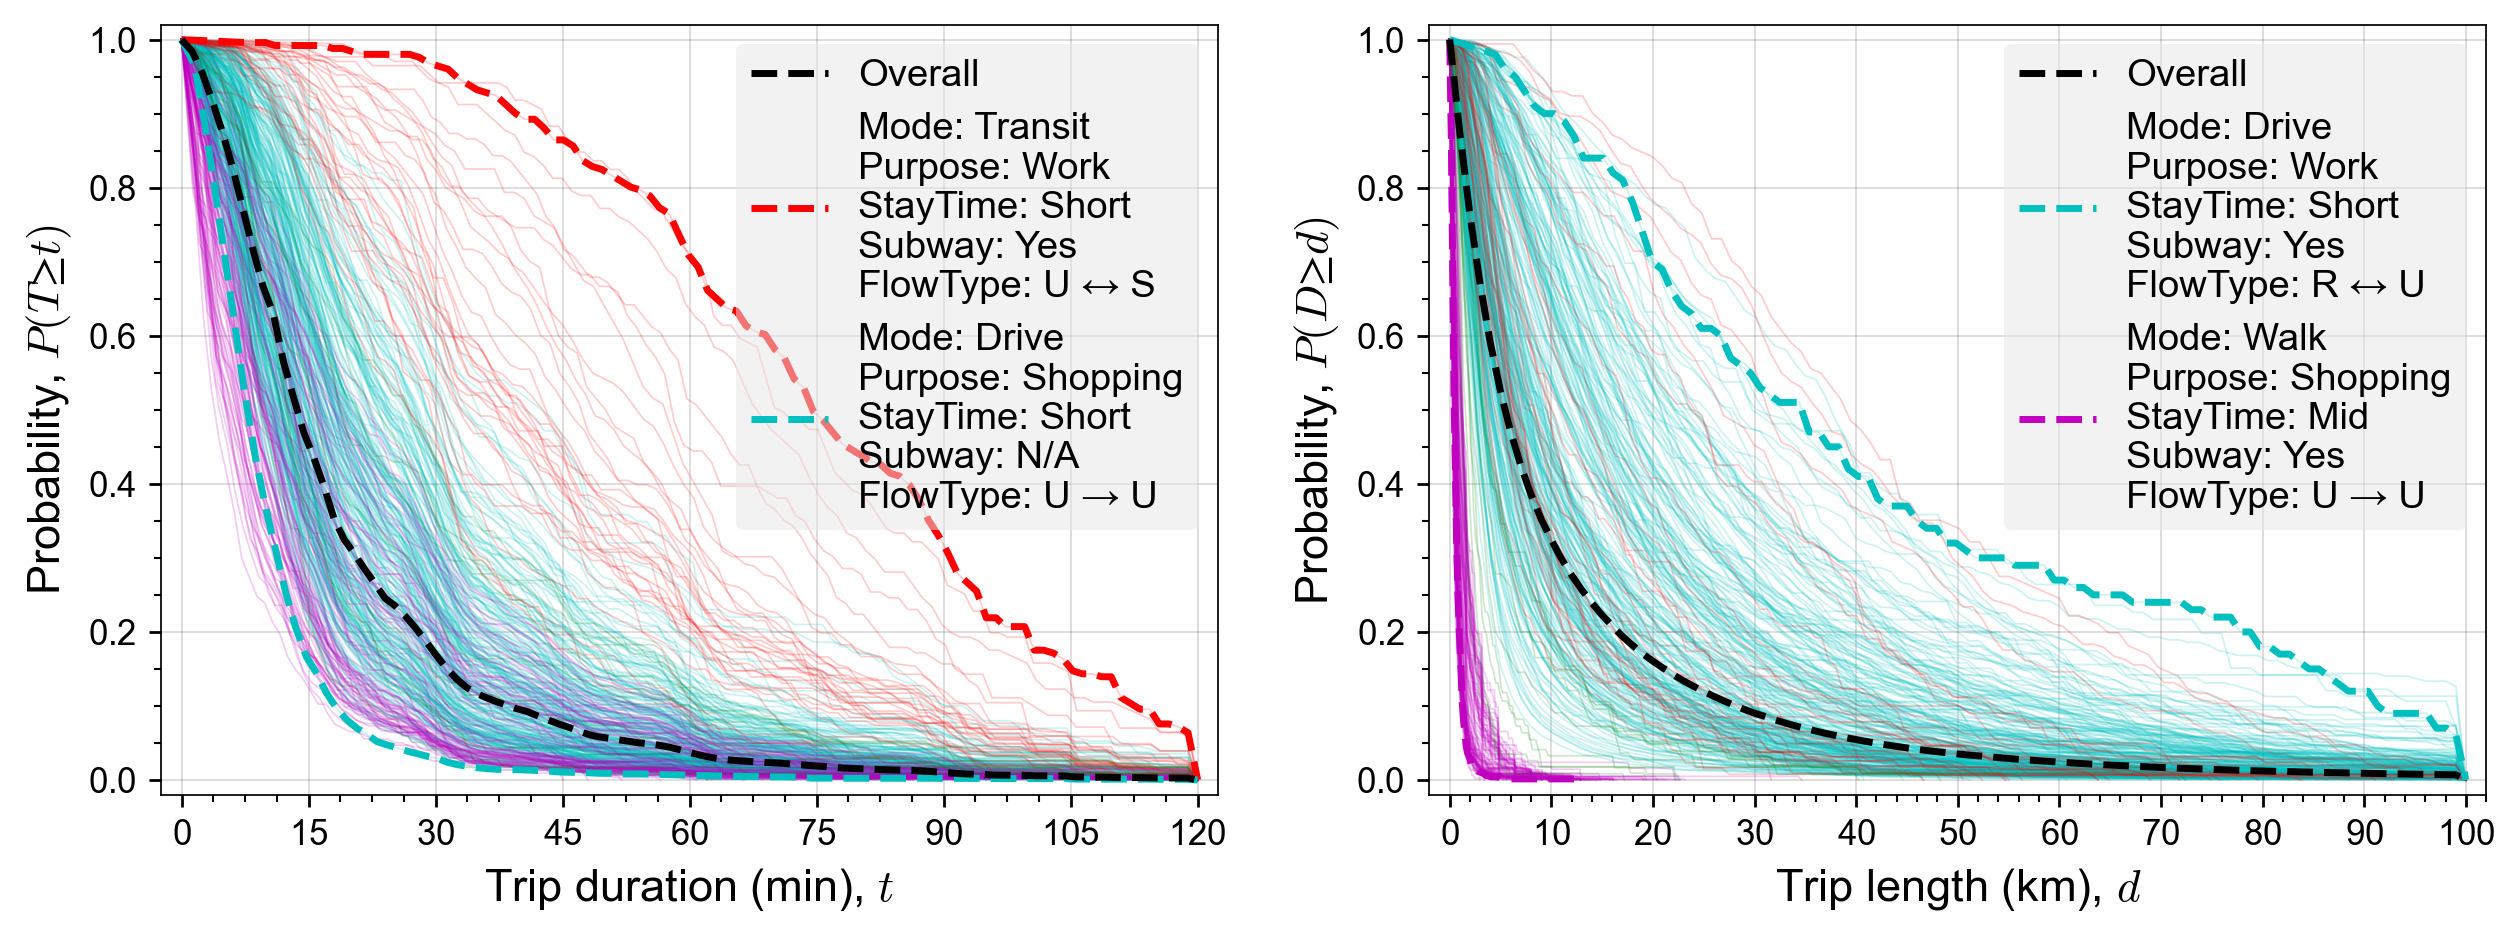

In [6]:
def plot_distr_final_vars(trips=trips, factors=sel_factors, dpi=150, pad=0.02, targets=(
    ('Duration', 0, 120, 15, 't', 'Trip duration (min)'),
    ('Distance', 0, 100, 10, 'd', 'Trip length (km)'),
)):
    ncol = len(targets)
    _, axes = plt.subplots(1, ncol, figsize=(6 * ncol, 4), dpi=dpi)
    distr = []
    for i, (trg, vmin, vmax, gap, s, label) in enumerate(targets):
        def hist(df):
            y, x = np.histogram(df[trg].clip(vmin, vmax), bins=100)
            x = Arr([0] + list(x[1:]))
            y = Arr([1] + list(1 - (y / y.sum()).cumsum()))
            area = 1 - (x * y).sum() / x.sum()
            return x, y, area
        colors = D(Drive='c', Transit='r', Walk='m', Bike='g')
        dx = pad * (vmax - vmin)
        ax = pplot(axes[i], xlim=(vmin - dx, vmax + dx),
                   ylim=(0 - pad, 1 + pad),
                   ylab='Probability, $P(%s≥%s)$' % (s.upper(), s),
                   xlab='%s, $%s$' % (label, s))
        x, y, _ = hist(trips)
        ax.plot(x, y, lw=2, ls='--', color='k', label='Overall', zorder=100)
        res = []
        for cols, df in trips.groupby(list(factors.keys())):
            if len(df) < 100: continue
            x, y, area = hist(df)
            cols = D(zip(factors.keys(), cols))
            ax.plot(x, y, lw=0.5, color=colors[cols['Mode']], alpha=0.2)
            res.append(cols | D(AUC=area))
        df = Pdf(res).sort_values('AUC').reset_index(drop=1)
        for i in [0, -1]:
            vals = df.iloc[i, :-1].to_dict()
            query = ' & '.join([f'{k}=="{v}"' for k, v in vals.items()])
            x, y, _ = hist(trips.query(query))
            label = '\n'.join([f'{k}: {v}' for k, v in vals.items()])
            ax.plot(x, y, lw=2, color=colors[vals['Mode']], label=label, ls='--')
        ax.set_xticks(np.arange(vmin, vmax + 1e-5, gap))
        ax.legend()
        distr.append(df.assign(Target=trg))
    return pd.concat(distr).reset_index(drop=1)

combs = plot_distr_final_vars(dpi=250).disp()
# x = plot_distr_final_vars(dpi=250); x

In [7]:
# plot_distr_final_vars(trips=trips, targets=(
#     ('Duration', 0, 120, 15, 't', 'Trip duration (min)'),
#     ('Distance', 0, 100, 10, 'd', 'Trip length (km)'),
#     ('Speed', 0, 100, 10, 'v', 'Mean speed (km/h)')));

## 3.2. Select the functional form

In [8]:
imped_funcs = {
    'Power': lambda x, a: x ** a,
    'Base exponential': lambda x, a: np.exp(a * x),
    'Sherratt Tanner': lambda x, a: np.exp(-a * (x ** 2)),
    'Logistic': lambda x, a: 2 * (1 + np.exp(a * x)) ** (-1),
    'Power exponential': lambda x, a, b: np.exp(-a * (x ** b)),
    'Tanner': lambda x, a, b: (x ** a) * np.exp(b * x),
    'Quadratic exponential': lambda x, a, b: np.exp(a * x - b * (x ** 2)),
    'Cubic exponential': lambda x, a, b, c: np.exp(-a * x + b * (x ** 2) - c * (x ** 3)),
}

In [9]:
def fit_decay_functions(funcs, combs, trips, factors=sel_factors):
    res = []
    for _, r in tqdm(combs.iterrows(), total=len(combs)):
        vmax = D(Duration=120, Distance=100)[r.Target]
        query = ' & '.join([f'{k}=="{v}"' for k, v in r[list(factors)].items()])
        vals = trips.query(query)[r.Target].clip(0, vmax)
        y, x = np.histogram(vals, bins=np.arange(0, vmax + 1))
        x, y = x[1:], 1 - (y / y.sum()).cumsum()
        for fname, func in funcs.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, x, y)[0]
                    yfit = func(x, *params)
                r2 = r2_score(y, yfit)
                if r2 < 0 or r2 > 1: continue
            except RuntimeError as e:
                print('ERROR:', fname, D(r), e)
                continue
            res.append(D(r) | D(Func=fname, R2=r2, Params=list(params)))
    res = Pdf(res)
    return res

# x = fit_decay_functions(imped_funcs, combs, trips); x
fitted = fit_decay_functions(imped_funcs, combs, trips).disp() # t=0:32

  0%|          | 0/790 [00:00<?, ?it/s]

ERROR: Cubic exponential {'Mode': 'Walk', 'Purpose': 'Work', 'StayTime': 'Very_Long', 'Subway': 'N/A', 'FlowType': 'U → U', 'AUC': 0.8844219527553309, 'Target': 'Distance'} Optimal parameters not found: Number of calls to function has reached maxfev = 800.
6,240 rows x 10 cols; Memory: 3.4 MiB


,Mode,Purpose,StayTime,Subway,FlowType,AUC,Target,Func,R2,Params
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<float64>,<object>
0,Transit,Work,Short,Yes,U ↔ S,0.562148,Duration,Power,0.305034,[-0.13405745515986953]


In [10]:
# ax = pplot(size=(4, 3), dpi=150, yminor=0)
# sns.barplot(fitted, y='Func', x='R2', hue='Target', ax=ax, palette='Pastel1');

In [11]:
(fitted.groupby(['Func', 'Target'])['R2'].describe()
 .reset_index().rename(columns=str.title)
 .melt(['Func', 'Target']).assign(
     Statistic=lambda df: pd.Categorical(
         df.variable, categories=['Mean', 'Std', 'Min', 'Max']))
 .pivot_table('value', 'Func', ['Target', 'Statistic'])
 .loc[list(imped_funcs.keys())].reset_index())

Target                      Func  Distance                                \
Statistic                             Mean       Std       Min       Max   
0                          Power  0.760497  0.136224  0.088206  0.956057   
1               Base exponential  0.978810  0.018177  0.872281  0.999369   
2                Sherratt Tanner  0.883901  0.064802  0.624119  0.996219   
3                       Logistic  0.967063  0.027215  0.819756  0.999261   
4              Power exponential  0.990857  0.008239  0.949769  0.999957   
5                         Tanner  0.991301  0.008133  0.927169  0.999807   
6          Quadratic exponential  0.987149  0.013909  0.876087  0.999761   
7              Cubic exponential  0.993902  0.005587  0.958460  0.999957   

Target     Duration                                
Statistic      Mean       Std       Min       Max  
0          0.629630  0.097817  0.301457  0.897585  
1          0.962307  0.033430  0.738079  0.997938  
2          0.964390  0.037196  0.717412  0.998354  
3          0.978753  0.023344  0.796257  0.998276  
4          0.994005  0.003929  0.969652  0.999415  
5          0.993587  0.010258  0.898675  0.999248  
6          0.991569  0.004912  0.964039  0.998974  
7          0.994597  0.003445  0.974069  0.999699

## 3.3 Coefficients of best fit

In [14]:
def table_imped_func_coef(
        trips=trips, factors=sel_factors, imped_funcs=imped_funcs,
        funcs=('Base exponential', 'Cubic exponential')):
    res = []
    funcs = {k: v for k, v in imped_funcs.items() if k in funcs}
    for target, vmax in D(Duration=120, Distance=100).items():
        def get_params(df):
            res = []
            vals = df[target].clip(0, vmax)
            y, x = np.histogram(vals, bins=np.arange(0, vmax + 1))
            x, y = x[1:], 1 - (y / y.sum()).cumsum()
            for fname, func in funcs.items():
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, x, y)[0]
                yfit = func(x, *params)
                r2 = r2_score(y, yfit)
                if r2 < 0 or r2 > 1:
                    continue
                params = {f'β{i + 1}': x for i, x in enumerate(params)}
                if fname in ['Power exponential', 'Cubic exponential']:
                    params['β1'] *= -1
                if fname == 'Cubic exponential':
                    params['β3'] *= -1
                res.append(D(Func=fname) | params)
            return Pdf(res).assign(Target=target)
        res.append(get_params(trips).assign(Factor='Overall', Level=''))
        for factor in factors:
            for level, df in trips.groupby(factor):
                res.append(get_params(df).assign(Factor=factor, Level=level))
    df = pd.concat(res)
    cat_cols = 'Func Target Factor Level'.split()
    for col in cat_cols:
        df[col] = ordered_factor(df[col])
    df = df.melt(cat_cols, var_name='Param')
    df = df.pivot_table('value', ['Factor', 'Level'], [
        'Target', 'Func', 'Param']).reset_index()
    return df
    
x = table_imped_func_coef(); x

Target    Factor       Level         Duration                              \
Func                         Base exponential Cubic exponential             
Param                                      β1                β1        β2   
0        Overall                    -0.053486         -0.033466 -0.001121   
1           Mode       Drive        -0.054185         -0.029514 -0.001398   
2           Mode     Transit        -0.019813         -0.001329 -0.000442   
3           Mode        Walk        -0.061537         -0.063283  0.000045   
4           Mode        Bike        -0.046344         -0.031013 -0.000781   
5        Purpose        Work        -0.040828         -0.018048 -0.001021   
6        Purpose    Shopping        -0.066287         -0.034387 -0.002137   
7        Purpose      Social        -0.059299         -0.035386 -0.001454   
8        Purpose     Medical        -0.041327         -0.016044 -0.001172   
9        Purpose  Recreation        -0.052780         -0.034846 -0.001001   
10      StayTime       Short        -0.054790         -0.038221 -0.000948   
11      StayTime         Mid        -0.060845         -0.034377 -0.001651   
12      StayTime        Long        -0.050606         -0.026939 -0.001274   
13      StayTime   Very_Long        -0.037205         -0.009424 -0.001155   
14        Subway         Yes        -0.047158         -0.033696 -0.000692   
15        Subway          No        -0.051327         -0.028647 -0.001219   
16        Subway         N/A        -0.056695         -0.034890 -0.001280   
17      FlowType       U → U        -0.063445         -0.046217 -0.001109   
18      FlowType       S → S        -0.062020         -0.039345 -0.001420   
19      FlowType       R → R        -0.059021         -0.048885 -0.000621   
20      FlowType       U ↔ S        -0.046977         -0.015115 -0.001653   
21      FlowType       S ↔ R        -0.037432         -0.008894 -0.001240   
22      FlowType       R ↔ U        -0.030251         -0.001607 -0.001084   

Target                       Distance                              \
Func                 Base exponential Cubic exponential             
Param             β3               β1                β1        β2   
0       9.352995e-06        -0.102612         -0.134344  0.002360   
1       1.139031e-05        -0.092331         -0.115035  0.001506   
2       1.700082e-06        -0.068551         -0.082446  0.000731   
3       7.720556e-07        -1.062233         -1.316625  0.186143   
4       6.464731e-06        -0.277081         -0.325299  0.009351   
5       7.406525e-06        -0.060263         -0.067634  0.000371   
6       1.771668e-05        -0.143999         -0.179372  0.003531   
7       1.222912e-05        -0.114152         -0.142984  0.002287   
8       8.722152e-06        -0.072742         -0.084891  0.000632   
9       8.510617e-06        -0.130048         -0.170808  0.003657   
10      8.223937e-06        -0.106923         -0.141395  0.002646   
11      1.378571e-05        -0.131552         -0.167557  0.003307   
12      1.021854e-05        -0.095984         -0.121351  0.001752   
13      7.836072e-06        -0.049721         -0.045201 -0.000220   
14      5.820304e-06        -0.104776         -0.147300  0.003315   
15      9.778862e-06        -0.096766         -0.126180  0.002236   
16      1.077575e-05        -0.105364         -0.136092  0.002277   
17      1.006152e-05        -0.222185         -0.293917  0.011139   
18      1.213499e-05        -0.131792         -0.169225  0.003504   
19      6.068642e-06        -0.099140         -0.137257  0.002921   
20      1.264016e-05        -0.084097         -0.093262  0.000505   
21      8.867248e-06        -0.045892         -0.036928 -0.000524   
22      7.255426e-06        -0.035270         -0.021850 -0.000630   

Target                
Func                  
Param             β3  
0      -1.899953e-05  
1      -9.491363e-06  
2      -4.201551e-06  
3      -1.413394e-02  
4      -1.115570e-04  
5      -2.443697e-

## 3.4 Factor importance

In [27]:
from lightgbm import LGBMRegressor, plot_tree

In [39]:
def get_comb_distr(trips=trips, factors=sel_factors):
    X = pd.get_dummies(trips[list(factors)], prefix_sep='__')
    for target, vmax in D(Duration=120, Distance=100).items():
        y = trips[target].clip(0, vmax)
        reg = LGBMRegressor(max_depth=5, verbose=-1).fit(X, y)
        print('R2 value: {:.3f}'.format(r2_score(y, reg.predict(X))))
        return reg

x = get_comb_distr(); x

R2 value: 0.154


LGBMRegressor(max_depth=5, verbose=-1)

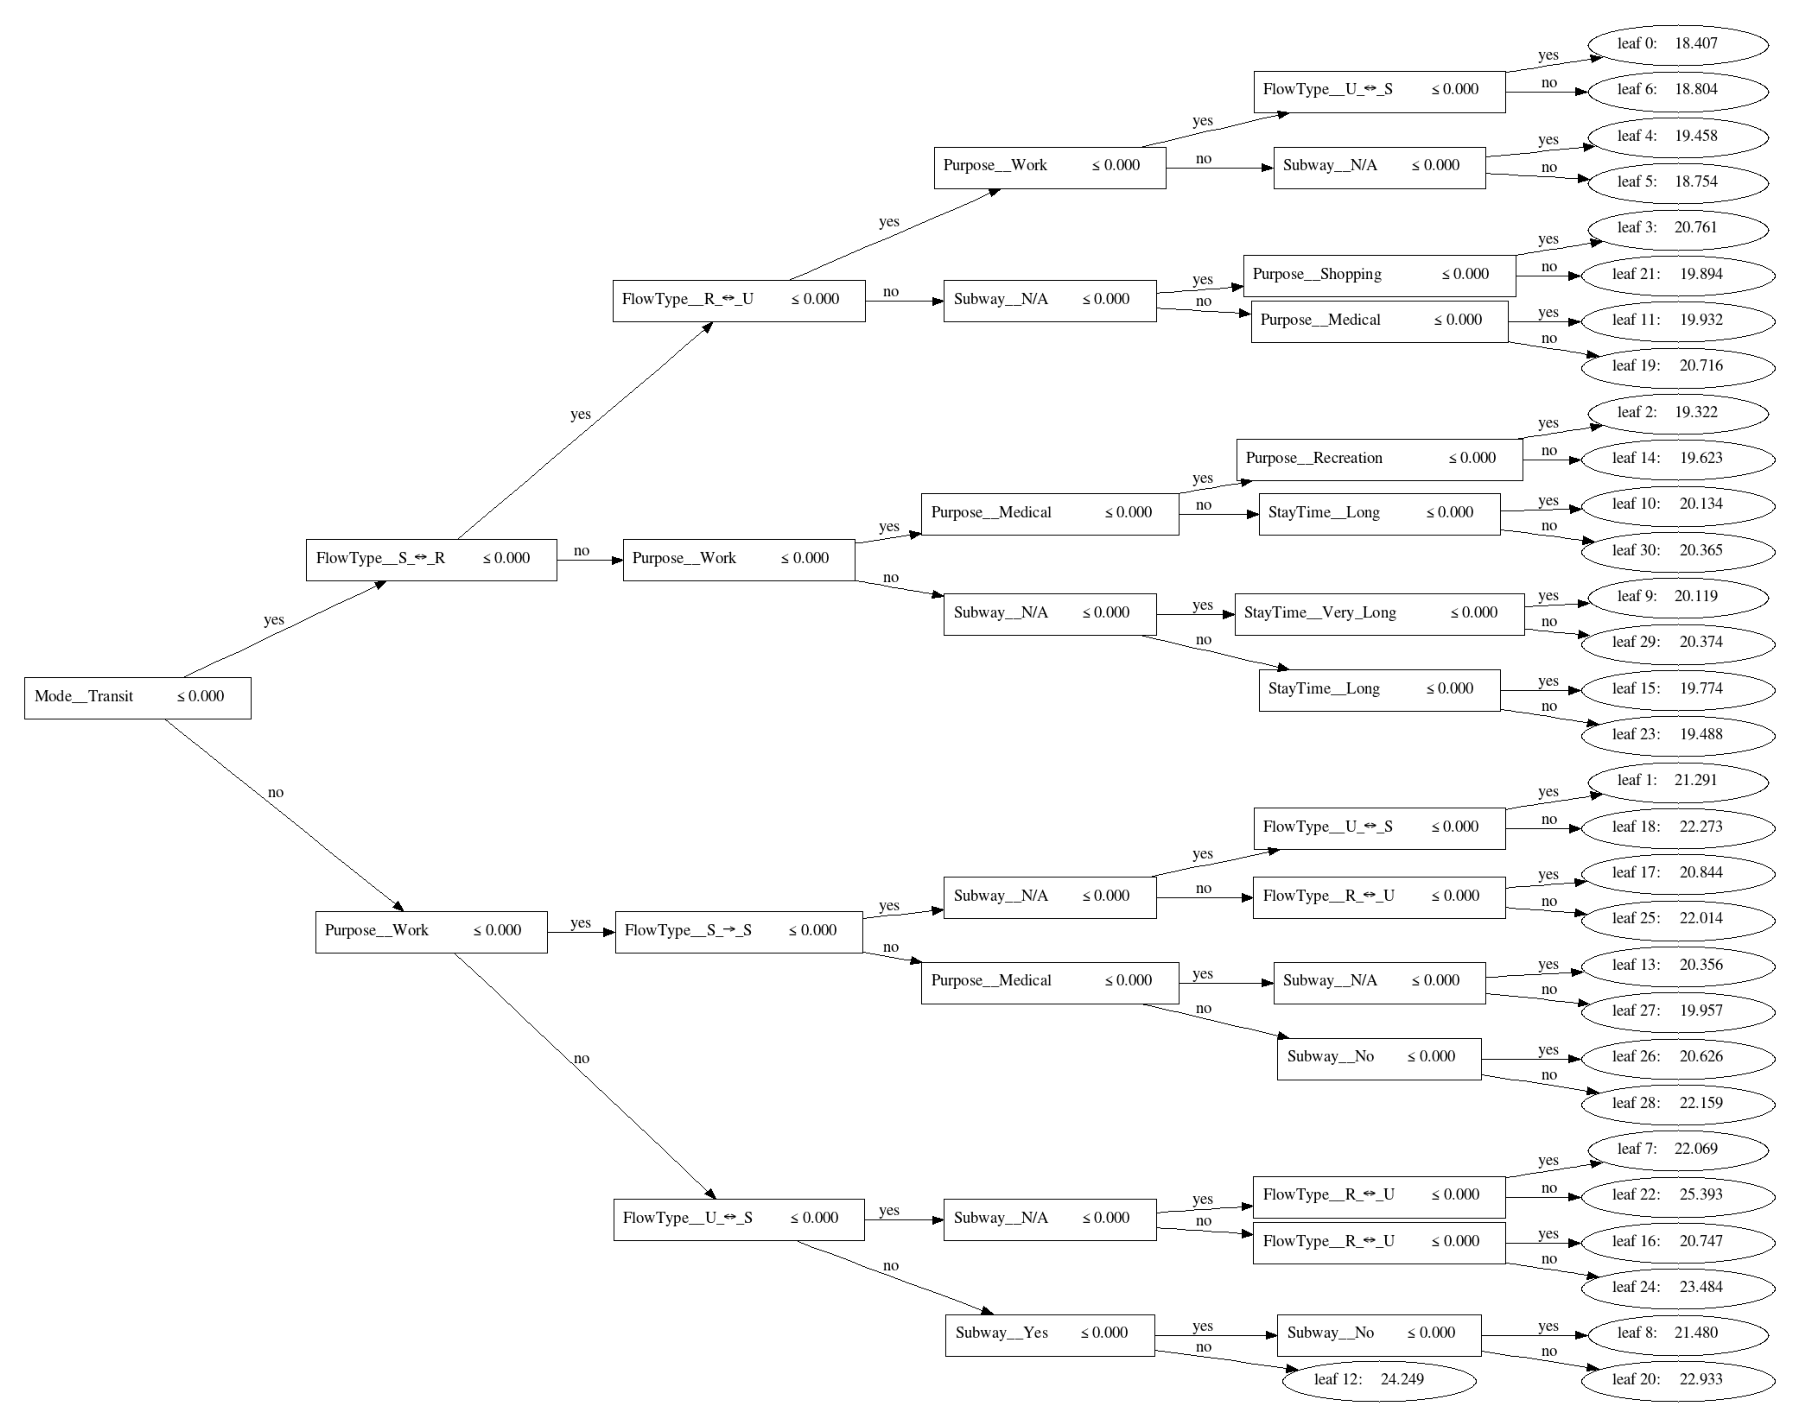

In [40]:
plot_tree(x.booster_, figsize=(12, 9), dpi=200, renderer='gd');

In [41]:
def get_comb_distr(trips=trips, factors=sel_factors):
    X = pd.get_dummies(trips[list(factors)], prefix_sep='__')
    for target, vmax in D(Distance=100, Duration=120).items():
        y = trips[target].clip(0, vmax)
        reg = LGBMRegressor(max_depth=5, verbose=-1).fit(X, y)
        print('R2 value: {:.3f}'.format(r2_score(y, reg.predict(X))))
        return reg

x = get_comb_distr(); x

R2 value: 0.183


LGBMRegressor(max_depth=5, verbose=-1)

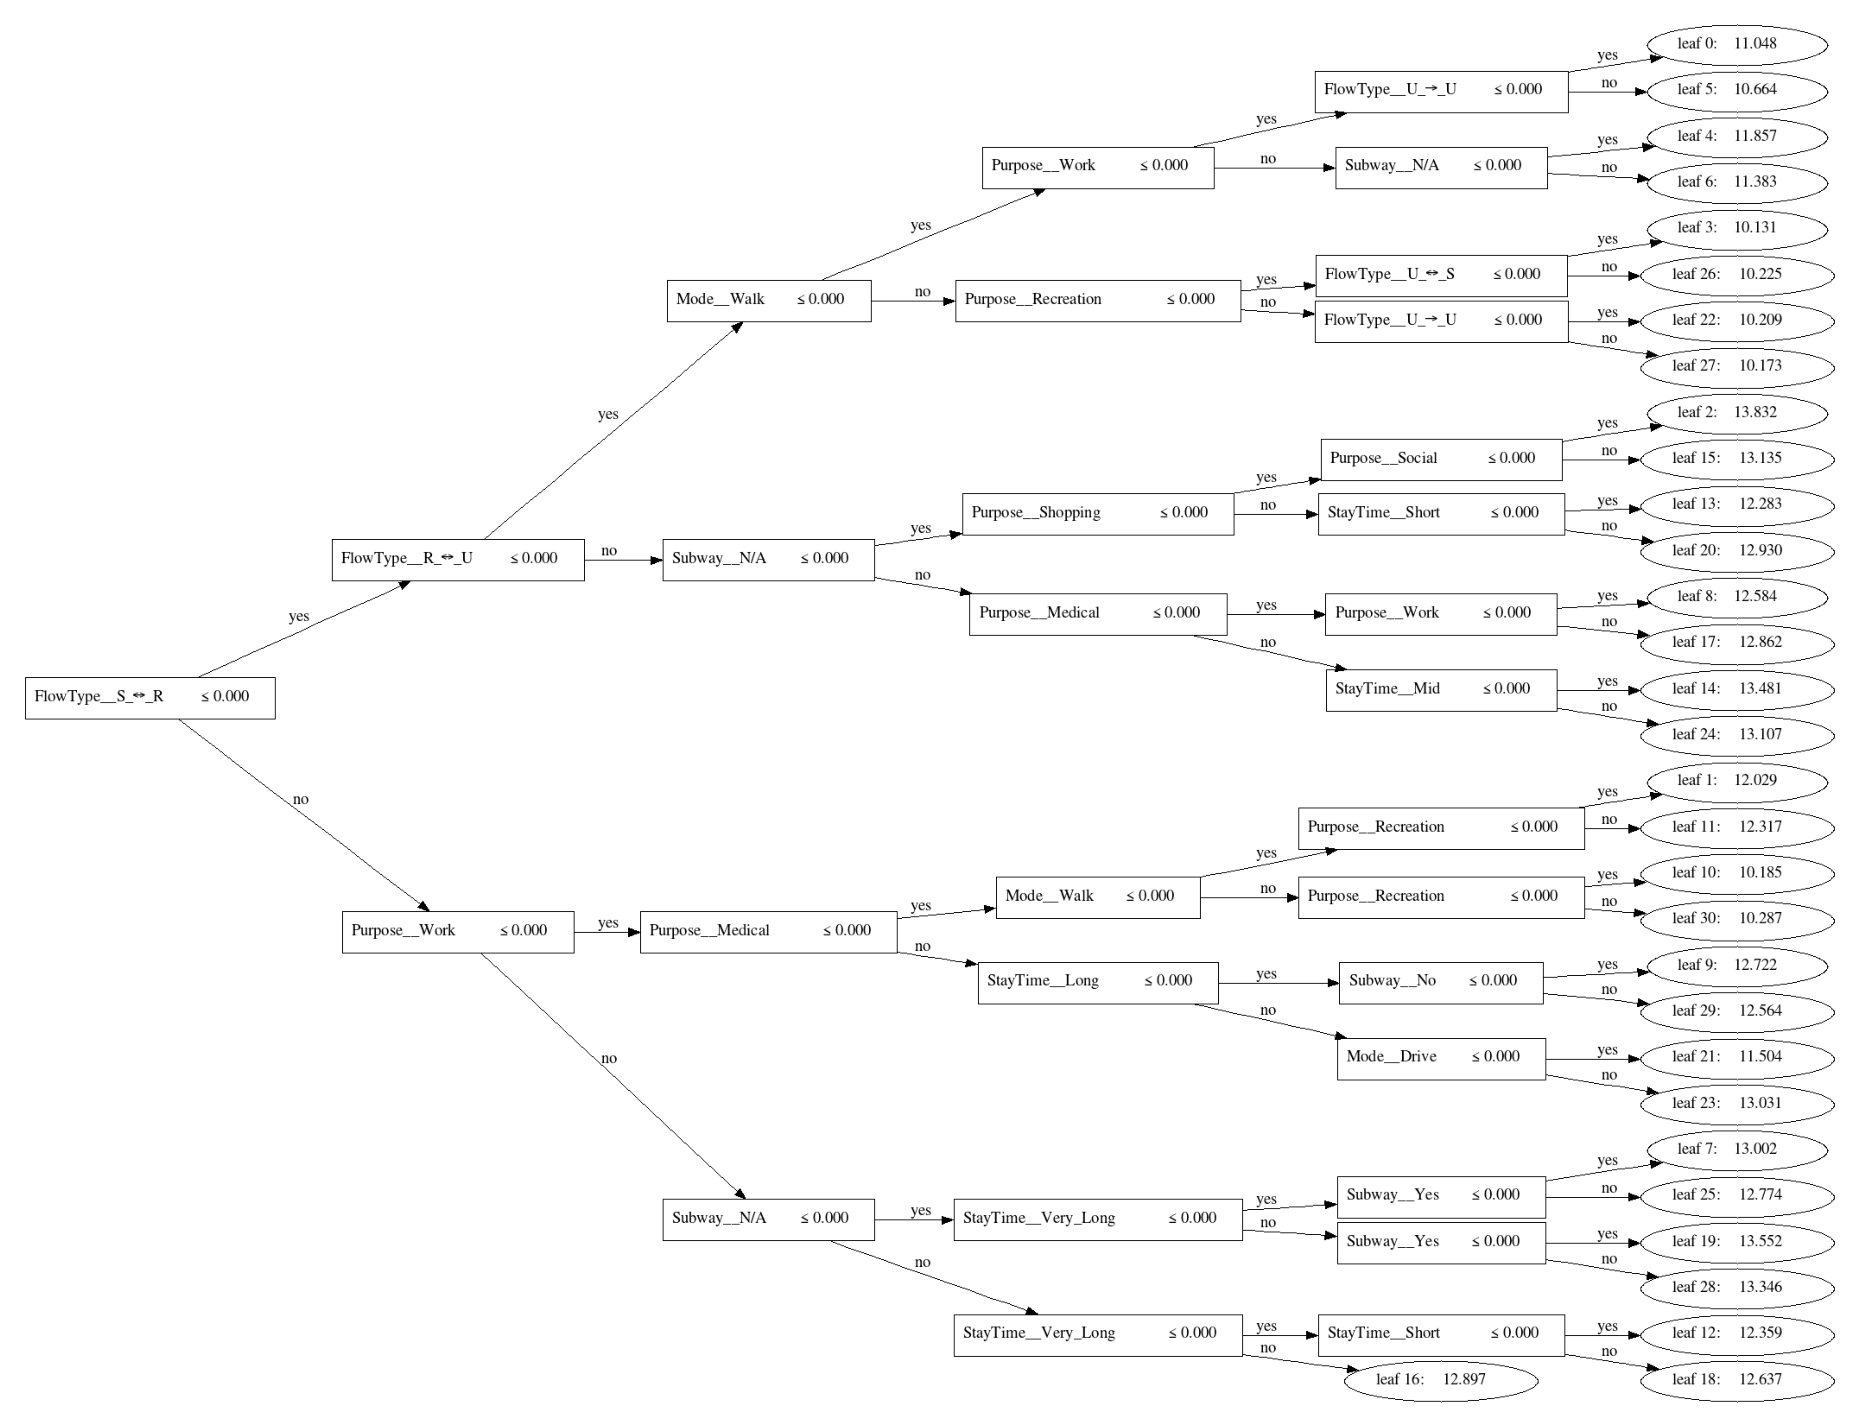

In [42]:
plot_tree(x.booster_, figsize=(12, 9), dpi=200, renderer='gd');

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
target = 'Distance'
df = fitted.query(f'Target=="{target}"')
X = pd.get_dummies(df.iloc[:, :5], prefix_sep='__')
reg = RandomForestRegressor(n_estimators=100, max_depth=10).fit(X, df.R2)
r2_score(df.R2, reg.predict(X))

0.049376158368664935

In [19]:
df = Pdf(D(variable=X.columns, imp=normalize(reg.feature_importances_)))
df['factor'], df['level'] = list(zip(*df.variable.str.split('__')))
df = df.groupby('factor')['imp'].sum().sort_values().reset_index()
df

,factor,imp
0,Mode,1.160854
1,Subway,2.261959
2,Purpose,2.343192
3,FlowType,2.541410
4,StayTime,2.658102
